# Mix of different classification algorithms

In [1]:
from __future__ import division
import graphlab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import timeit
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import graphviz
from sklearn import feature_selection

In [2]:
data_path ='C:\Users\josep\Documents\University of Toronto\Summaries\\fromPythonCurveFitSimilarRowColumnAvgv3145.csv' 
data = graphlab.SFrame(data_path)

This non-commercial license of GraphLab Create for academic use is assigned to joseph.j.ng3698@gmail.com and will expire on May 24, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\josep\AppData\Local\Temp\graphlab_server_1540732822.log.0


Finished parsing file C:\Users\josep\Documents\University of Toronto\Summaries\fromPythonCurveFitSimilarRowColumnAvgv3145.csv

Parsing completed. Parsed 100 lines in 0.103719 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,str,str,str,str,str,str,long,str,long,long,long,str,str,long,str,float,float,float,float,float,float,float,float,float,float,float,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long,float,float,float,float,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
---------------------------------------

Finished parsing file C:\Users\josep\Documents\University of Toronto\Summaries\fromPythonCurveFitSimilarRowColumnAvgv3145.csv

Parsing completed. Parsed 3145 lines in 0.078788 secs.

In [3]:
columns_to_remove = ['Identifier', 'Model', 'Has a Heat Pump', 'filename', 
                    'Number of Remote Sensors', 'Auxiliary Heat Fuel Type', 'Country', 'Province/State', 'fill']

for column in columns_to_remove:
    data.remove_column(column)

In [4]:
# Converting style of home to a categorical variable 
categoricalStyle = data['Style']
categoricalStyle = pd.get_dummies(categoricalStyle)
data = data.to_dataframe()
data = data.merge(categoricalStyle, left_index=True, right_index=True)


In [5]:
# Pick and choose the time period that we are interested in
#winter = ['2017_01','2017_02','2017_03' ] 
#spring = ['2017_04','2017_05','2017_06','2016_04','2016_05','2016_06' ] 
#summer = ['2017_07','2017_08','2017_09','2016_07','2016_08','2016_09' ] 
#fall = ['2016_10','2016_11','2016_12' ] 
#cities = ['Austin', 'San Diego', 'Nashville','Toronto', 'Chicago', 'Calgary', 'Miami']
summer = ['2017_07']
winter = ['2017_01']

# Pick and choose the features that we are interested in

timeOfInterest = summer + winter
climateZone = ['ASHRAE Climate Zone']
modelFeatures = ['Floor Area [ft2]', 'Number of Occupants', 'Number of Floors', 'Age of Home [years]']
houseStyles = ['Apartment','Condominium','Detached','Loft','MultiPlex','RowHouse','SemiDetached','Townhouse']
interestedFeatures = ['Floor Area [ft2]', 'Number of Occupants', 'Number of Floors', 'Age of Home [years]']

# Obtain environmental parameters
indoorRH = []
indoorTemp = []
outdoorRH = []
outdoorTemp = []
adjustments = []

for month in timeOfInterest:
    indoorRH.append('{month} Indoor RH'.format(month=month))
    indoorTemp.append('{month} Indoor Temp'.format(month = month))
    outdoorRH.append('{month} Outdoor RH'.format(month = month))
    outdoorTemp.append('{month} Outdoor Temp'.format(month = month))
    adjustments.append('{month} Adjust'.format(month = month))


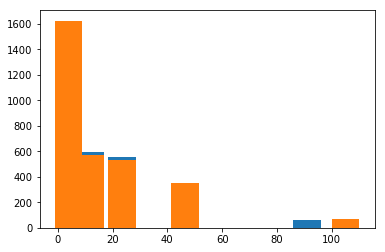

In [135]:
# Bins are based on [twice per week, every other day, every day, twice per day]

%matplotlib inline

binsWinter = [0, 8, 16, 31, 62, data['2017_01 Adjust'].max()]
histWinter, binsWinter = np.histogram(data['2017_01 Adjust'], bins=binsWinter)
widthsWinter = 10
centerWinter = (binsWinter[:-1] + binsWinter[1:])/2

binsSummer = [0, 8, 16, 31, 62, int(data['2017_07 Adjust'].max())]
histSummer, binsSummer = np.histogram(data['2017_07 Adjust'], bins=binsSummer)
widthsSummer = 10
centerSummer = (binsSummer[:-1] + binsSummer[1:])/2

plt.bar(centerWinter, histWinter, align='center', width=widthsWinter)
plt.bar(centerSummer, histSummer, align='center', width=widthsSummer)
plt.show()

# Choose 1 Function to create a target column

createTargetColumnBinary: Creates 2 classes. Comfortable if number of comfortable months > uncomfortable months
<br>
createMultipleTargetColumn: Creates multiple classes based on predefined bins
<br>
createMultipleTargetColumn3Class: Creates 3 classes. [Comfortable, uncomfortable, undecided]. 
<br>
Undecided if there are 2 months and each month is split between comfortable and uncomfortable. 
<br>
Undecided if there are 3 months and there is a mix of months that are comfortable and uncomfortable


In [176]:
# Creating the target columns
# A house is comfortable if the number of thermostat adjustments for that month is less than the average thermostat adjustments
# for that month
# If the house is uncomfortable for more than half of the months, then the target column = 'Uncomfortable'
def createTargetColumnBinary(data, adjustments):
    dataTargetColumn = data[adjustments]
    target = []

    for i in range(0, len(dataTargetColumn)):
        comfortableCounter = 0
        uncomfortableCounter = 0
        dataPoint = dataTargetColumn.iloc[i, :]

        for j in range(0, len(adjustments)):
            if dataPoint[j] <= dataTargetColumn.iloc[:, j].mean():
                comfortableCounter += 1
            else:
                uncomfortableCounter += 1
            
        if comfortableCounter > uncomfortableCounter:
            target.append('Comfortable')
        else:
            target.append('Uncomfortable')

    return target

testTarget = createTargetColumnBinary(data, adjustments)


In [136]:
# Creating target column with multiple classes based on the bins created previously 
def createMultipleTargetColumn(data, adjustments, binsWinter, binsSummer):
    dataTargetColumn = data[adjustments]
    maxAdjustment = dataTargetColumn.max()
    targetSummer = []
    targetWinter = []
    
    for i in range(0, len(dataTargetColumn)):
        comfortableCounter = 0
        uncomfortableCounter = 0
        dataPoint = dataTargetColumn.iloc[i, :]

        for j in range(0, len(adjustments)):
            if adjustments[j] == '2017_01 Adjust':
                for k in range(1, len(binsWinter)+1):
                    if dataPoint[j] <= binsWinter[k]:
                        targetWinter.append(k)
                        break
            else:
                for m in range(1, len(binsSummer)+1):
                    if dataPoint[j] <= binsSummer[m]:
                        targetSummer.append(m)
                        break

    return targetWinter, targetSummer
  
targetWinter, targetSummer = createMultipleTargetColumn(data, adjustments,
                                                        binsWinter, binsSummer)

In [6]:
# Explanation for how the classes are created can be found above

def createMultipleTargetColumn3Class(data, adjustments):
    dataTargetColumn = data[adjustments]
   
    target = []

    for i in range(0, len(dataTargetColumn)):
        comfortableCounter = 0
        uncomfortableCounter = 0
        dataPoint = dataTargetColumn.iloc[i, :]

        for j in range(0, len(adjustments)):
            if dataPoint[j] <= dataTargetColumn.iloc[:, j].mean():
                comfortableCounter += 1
            else:
                uncomfortableCounter += 1
            
        if comfortableCounter > uncomfortableCounter:  # uncomfortableCounter: # and comfortableCounter >=4:
            target.append('Comfortable')
        elif uncomfortableCounter > comfortableCounter:  # comfortableCounter: # uncomfortableCounter: # and comfortableCounter <=2:
            target.append('Uncomfortable')
        else:
            target.append('Undecided')

    return target

testTarget = createMultipleTargetColumn3Class(data, adjustments)

In [7]:
# Checking class instability 
print len([i for i, x in enumerate(testTarget) if x == 'Uncomfortable'])
print len([i for i, x in enumerate(testTarget) if x == 'Comfortable'])
print len([i for i, x in enumerate(testTarget) if x == 'Undecided'])

645
1685
815


In [137]:
# creating final target column
testTarget = []
for i in range(0, len(targetWinter)):
    testTarget.append(int((targetWinter[i] + targetSummer[i])/2))

print "Number of data points in each class label"
for j in range(1, len(binsWinter)):
    test = [i for i, x in enumerate(testTarget) if x == j]
    testWinter = [i for i, x in enumerate(targetWinter) if x == j]
    testSummer = [i for i, x in enumerate(targetSummer) if x == j]
    print len(testWinter)
    print len(testSummer)
    print len(test)

Number of data points in each class label
1696
3791
1626
558
1020
1131
520
923
342
315
475
46
56
81
0


In [8]:
dataOriginal = pd.DataFrame(data, copy = True)
dataNormalized = pd.DataFrame(data, copy = True)

In [9]:
# Choosing which features are included in the model 
features =  interestedFeatures + houseStyles + climateZone + indoorTemp + indoorRH + outdoorTemp + outdoorRH
#features =  interestedFeatures + houseStyles + climateZone + indoorTemp + indoorRH + outdoorTemp + outdoorRH
#features = indoorTemp + indoorRH + outdoorTemp + outdoorRH
features

['Floor Area [ft2]',
 'Number of Occupants',
 'Number of Floors',
 'Age of Home [years]',
 'Apartment',
 'Condominium',
 'Detached',
 'Loft',
 'MultiPlex',
 'RowHouse',
 'SemiDetached',
 'Townhouse',
 'ASHRAE Climate Zone',
 '2017_07 Indoor Temp',
 '2017_01 Indoor Temp',
 '2017_07 Indoor RH',
 '2017_01 Indoor RH',
 '2017_07 Outdoor Temp',
 '2017_01 Outdoor Temp',
 '2017_07 Outdoor RH',
 '2017_01 Outdoor RH']

In [10]:
# Function to normalize the data (scale between 0 and 1)
def normalize(column):
    newColumn = []
    maxValue = max(column)
    minValue = min(column)

    for i in range(0, len(column)):

        normalizedValue = (column[i] - minValue) / (maxValue - minValue)
        newColumn.append(normalizedValue)

    return newColumn, maxValue, minValue

In [11]:
# Normalizing the data

combined = features
dataNormalized = dataNormalized.reset_index(drop=True)
dataUnnormalized = pd.DataFrame(dataNormalized, copy=True)  # creating a copy of the original with the same index
dataToNormalize = dataNormalized[combined]

maxVals = []
minVals = []
minMaxdf = pd.DataFrame({'Value': ['Min', 'Max']})

for i in list(dataToNormalize.columns.values):
    dataColumn = dataToNormalize[i]
    normalizedColumn, maxValue, minValue = normalize(dataColumn)
    dataToNormalize[i] = normalizedColumn
    maxVals.append(maxValue)
    minVals.append(minValue)
    minMaxdf[i] = [minValue, maxValue]
dataNormalized.update(dataToNormalize)


C:\Users\josep\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
x = dataNormalized[features]
y = testTarget

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, random_state = 0)

In [65]:
#class_weight = 'balanced'
class_weight = None
scoring = 'accuracy'
#scoring = 'f1_weighted'

In [67]:
def nested_cv(model, param, x_train, y_train):
    cv_inner = KFold(n_splits=10, shuffle=True, random_state=0)
    cv_outer = KFold(n_splits =10, shuffle=True, random_state=0)
    start = timeit.default_timer()
    
    # Inner Loop
    clf = GridSearchCV(estimator = model, param_grid=param, cv=cv_inner, scoring=scoring)
    
    # Outer Loop
    nested_scores = cross_val_score(clf, X=x_train, y=y_train, cv=cv_outer)
    nested_score_avg = scores.mean()
    nested_score_std = scores.std()
                                        
    stop = timeit.default_timer()
    print('Time: ', stop - start) 
    return nested_scores, nested_score_avg, nested_score_std
    


In [68]:
dt = tree.DecisionTreeClassifier(class_weight=class_weight)
rf = ensemble.RandomForestClassifier(class_weight=class_weight)
models = [dt, rf]
num_trials = 1
nested_scores = []

params = [{'max_depth': range(3, 20), 
         'criterion': ['gini', 'entropy'],
        'min_samples_split': np.linspace(0.1, 0.5, 5),
         'min_samples_leaf': np.linspace(0.01,0.5,5),
        'min_impurity_decrease': np.linspace(0.1,0.4,4)},
         {'n_estimators': np.arange(10,25,5), 'max_depth': range(3, 20), 
          'max_features': ['auto', 'log2', None], 'min_samples_split': np.linspace(0.1,0.5,5), 
          'criterion': ['gini', 'entropy']}]



In [ ]:
nested_score_dt, nested_score_avg_dt, nested_score_std_dt = nested_cv(dt, params[0], x_train, y_train)
nested_score_rf, nested_score_avg_rf, nested_score_std_rf = nested_cv(rf, params[1], x_train, y_train)

print "Decision Tree Results"
print nested_score_dt
print nested_score_avg_dt
print nested_score_std_dt
print "Random Forest Results"
print nested_score_rf
print nested_score_avg_rf
print nested_score_std_rf

In [ ]:
# If you are happy with the unbiased performance, retrain the model using all of the training data on the best parameters. 
clf.fit(x_train,y_train)
print clf.best_params_
optimal_criterion = clf.best_params_.get('criterion')
optimal_min_samples_split = clf.best_params_.get('min_samples_split')
optimal_max_depth = clf.best_params_.get('max_depth')
optimal_min_samples_leaf = clf.best_params_.get('min_samples_leaf')

In [162]:
# retraining model so it does not have to initiate a GridSearchCV every time
model = tree.DecisionTreeClassifier(class_weight=class_weight, criterion=optimal_criterion, random_state=0,
                                    max_depth=optimal_max_depth, 
                                    min_samples_split=optimal_min_samples_split,
                                    #min_samples_leaf=optimal_min_samples_leaf, 
                                    splitter='best').fit(x_train, y_train)

In [163]:
# Obtaining model accuracy 
print "Training Set Accuracy: " + str(model.score(x_train, y_train))
prediction = model.predict(x_test)
print "Test Set Accuracy: " + str(accuracy_score(y_test, prediction, normalize=True))

# If you are happy with the test and training accuracies, then you are finished. The test accuracy should not be significantly different
# from the training and nested accuracies. 
# If you are happy with the test and training accuracies, then you are finished

Training Set Accuracy: 0.202120141343
Test Set Accuracy: 0.15873015873


In [49]:
# Obtain feature importances
importance = [x for x in model.feature_importances_]
featureImportance = {'Feature': features, 'Importance': importance}
summary = pd.DataFrame(data=featureImportance)
summarySorted = summary.sort_values(by=['Importance'], ascending=False)
summarySorted

,Feature,Importance
4,2017_01 Outdoor Temp,0.575229
5,2017_07 Outdoor Temp,0.234464
6,2017_01 Outdoor RH,0.190307
0,2017_01 Indoor Temp,0.000000
1,2017_07 Indoor Temp,0.000000
2,2017_01 Indoor RH,0.000000
3,2017_07 Indoor RH,0.000000
7,2017_07 Outdoor RH,0.000000


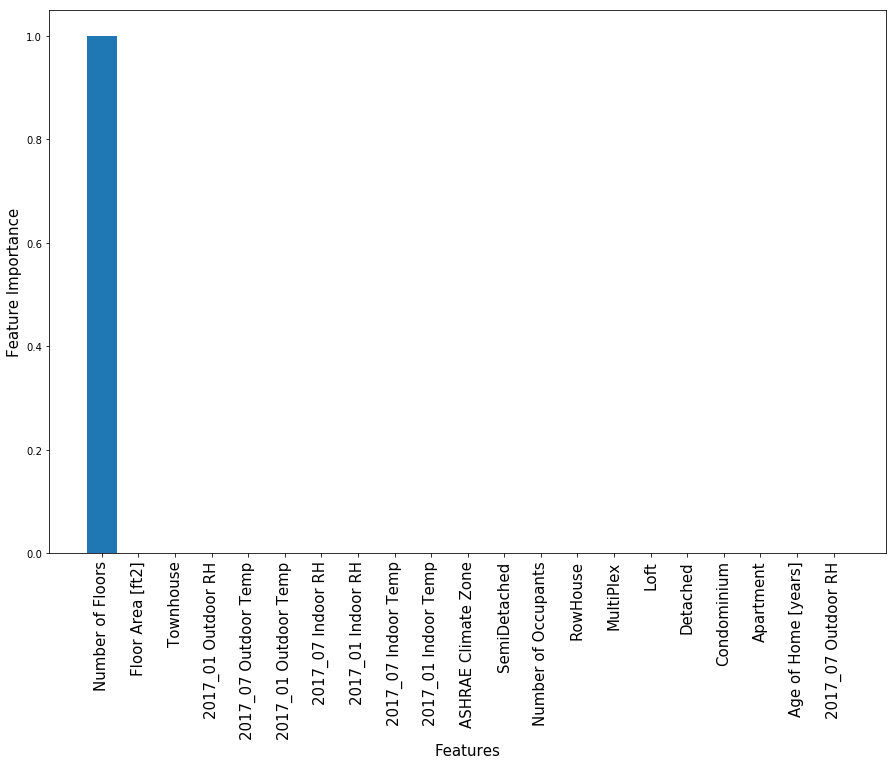

In [87]:
# Plot feature importances ranking
% matplotlib inline
plt.figure(figsize=(15, 10))
plt.bar(range(0, len(summarySorted)), summarySorted['Importance'], align='center')
plt.xticks(range(0, len(summarySorted)), summarySorted['Feature'], rotation=90)
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.rc('xtick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.show()

In [302]:
# Function to un-normalize data

def unnormalize(column, minValue, maxValue):
    newColumn = []

    for i in range(0, len(column)):

        originalValue = column.iloc[i] * (maxValue - minValue) + minValue
        newColumn.append(originalValue)

    return newColumn

In [133]:
# Confusion matrix to count false positives/negatives
# Rows = actual, columns = prediction
confusion_matrix(y_test, prediction, labels=['Comfortable', 'Undecided', 'Uncomfortable'])

array([[114,   0,  96],
       [  0,   0,   0],
       [ 33,   0,  72]], dtype=int64)

In [157]:
prediction

array([1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1,

In [164]:
confusion_matrix(y_test, prediction)

array([[21, 16, 98, 23],
       [17, 11, 77, 17],
       [ 4,  4, 17,  3],
       [ 1,  0,  5,  1]], dtype=int64)

# Code that is not longer used

In [ ]:
# Hyperparameter tuning using GridSearchCV 
# Minimum size for split, max depth, criterion, minimal gain, minimum leaf size
# Run this when you get home

dt = tree.DecisionTreeClassifier(class_weight=class_weight)
rf = ensemble.RandomForestClassifier(class_weight=class_weight)
models = [dt, rf]
num_trials = 1
nested_scores = []
start = timeit.default_timer()

params = [{'max_depth': range(3, 20), 
         'criterion': ['gini', 'entropy'],
        'min_samples_split': np.linspace(0.1, 0.5, 5),
         'min_samples_leaf': np.linspace(0.01,0.5,5),
        'min_impurity_decrease': np.linspace(0.1,0.4,4)},
         {'n_estimators': np.arange(200,2200,200), 'max_features': ['auto', 'sqrt', 'log2', None],
         'min_samples_split': np.linspace(0.1,0.5,5), 'min_samples_leaf': np.linspace(0.01,0.5,5),
         'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}]
cv_scores_avg = [[] for _ in range(len(models))]
cv_scores_std = [[] for _ in range(len(models))]

for i in range(0,num_trials):
     for j, (model, param) in enumerate(zip(models, params)):  
        print model
        print param
        cv_inner = KFold(n_splits=10, shuffle=True, random_state=i)
        cv_outer = KFold(n_splits =10, shuffle=True, random_state=i)

        # Inner Loop
        clf = GridSearchCV(estimator = model, param_grid=param, cv=cv_inner, scoring=scoring)

        # Outer Loop
        scores = cross_val_score(clf, X=x_train, y=y_train, cv=cv_outer)
        nested_score_avg = scores.mean()
        nested_score_std = scores.std()
        nested_scores.append(nested_score_avg)
        cv_scores_avg.append(nested_score_avg)
        cv_scores_std.append(nested_score_std)
        print nested_score_avg
                                        
stop = timeit.default_timer()
print('Time: ', stop - start) 
print scores  # These are scores on the outer folds for you to assess the performance of the model fitting approach 
print cv_scores_avg  # This score is a unbiased estimate of the performance of the model
print cv_scores_std  # This should be as low as possible 

In [ ]:
# Alternative way of conducting nested cross validation 
dt = tree.DecisionTreeClassifier()
cv_inner = KFold(n_splits=10, shuffle=True, random_state=0)
cv_outer = KFold(n_splits=10, shuffle=True, random_state=0)
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)


outer_loop_scores = []
for train_outer_index, test_outer_index in cv_outer.split(x_train):
    x_outer_train, x_outer_test = x_train.loc[train_outer_index,:], x_train.loc[test_outer_index]
    
    y_outer_train = []
    y_outer_test = []
    
    # Obtaining splits for y in outer loop
    for index in train_outer_index:
        y_outer_train.append(y_train[index])
        y_outer_test.append(y_train[index])
        
    # Initialize first cross validation loop
    clf = GridSearchCV(estimator = dt, param_grid=param, cv=cv_inner, scoring='accuracy')
    clf.fit(x_outer_train, y_outer_train)
    
    outer_loop_scores.append(clf.best_score_)
        
print outer_loop_scores
print outer_loop_scores.mean()
print outer_loop_scores.std()


In [ ]:
# Fitting the model with the tuned hyperparameters

model = tree.DecisionTreeClassifier(class_weight=None, criterion=optimalCriterion, random_state=0,
                                    max_depth=optimalDepthGSCV, splitter='best').fit(x_train, y_train)

#model = tree.DecisionTreeClassifier(class_weight = None, criterion = optimalCriterion, random_state = 0,
                                    #max_depth = None, splitter = 'best').fit(x_train,y_train)
# exporting into graphviz
#dot_data = tree.export_graphviz(model, out_file = None, feature_names = features, class_names = y_train, filled = True, rounded = True,
                               #special_characters = True)
#graph = graphviz.Source(dot_data)
#graph

# Exporting into pdf using pydot
#graph = pydot.graph_from_dot_data(dotfile.getvalue())
#graph[0].write_pdf("summer.pdf")
#colors = ('turquoise', 'orange')


#graph.write_png('summer.png')

In [ ]:
#removes all columns with indoor temperature and indoor relative humidity
columnIndoorTemp = []
columnIndoorRH = []
columnOutdoorRH = []
columnOutdoorTemp = []
yearMonth = []
for i in range(2016,2018):
    for j in range(4,13): #Need to adjust this value depending on which columns have been deleted
        if i == 2017 and j == 10:
            break

        if j < 10:
            columnIndoorTemp.append(str(i) + '_' + '0' + str(j) + ' Indoor Temp')
            columnIndoorRH.append(str(i) + '_' + '0' + str(j) + ' Indoor RH')
            columnOutdoorRH.append(str(i) + '_' + '0' + str(j) + ' Outdoor RH')
            columnOutdoorTemp.append(str(i) + '_' + '0' + str(j) + ' Outdoor Temp')
            yearMonth.append(str(i) + '_' + '0' + str(j))
        else: 
            columnIndoorTemp.append(str(i) + '_' + str(j) + ' Indoor Temp')
            columnIndoorRH.append(str(i) + '_' + str(j) + ' Indoor RH')
            columnOutdoorRH.append(str(i) + '_' + str(j) + ' Outdoor RH')
            columnOutdoorTemp.append(str(i) + '_' + str(j) + ' Outdoor Temp')
            yearMonth.append(str(i) + '_' + str(j))

        #data = data.drop(columnIndoorTemp,1)
        #data = data.drop(columnIndoorRH,1)
        #data = data.drop(columnOutdoorRH,1)
        #data = data.drop(columnOutdoorTemp,1)


In [ ]:
# Create histogram of adjustments
# Failed first attempt at binning the data
#numBins = 6
#histWinter,binsWinter = np.histogram(data['2017_01 Adjust'], bins = numBins)
#widthsWinter = 0.7*(binsWinter[1] - binsWinter[0])
#centerWinter = (binsWinter[:-1]+binsWinter[1:])/2

#histSummer, binsSummer = np.histogram(data['2017_07 Adjust'], numBins)
#widthsSummer = 0.7*(binsSummer[1] - binsSummer[0])
#centerSummer = (binsSummer[:-1] + binsSummer[1:])/2

#plt.bar(centerWinter, histWinter, align = 'center', width = widthsWinter)
#plt.bar(centerSummer, histSummer, align = 'center', width = widthsSummer)

#plt.show()
#print binsWinter
#print binsSummer

In [ ]:
# Plotting cross validation score vs the max depth of the tree
%matplotlib inline
plt.plot(range(3,20),[t for t in maxDepthArray])
plt.plot(range(3,20),[p for p in minScoreArray])
plt.plot(range(3,20),[s for s in maxScoreArray])
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('CV Accuracy')


In [ ]:
# Using SelectKBest to see the scores of the features

selector = feature_selection.SelectKBest(feature_selection.f_classif, k = 'all')
selector.fit_transform(x,y)
test = pd.DataFrame({'Features': features, 'Scores': selector.scores_,
                     'P-Value': selector.pvalues_})
test = test.sort_values('Scores', ascending = False)

# Using RFECV to select the best features
shuffle = KFold(n_splits = 10, shuffle = True, random_state = 0)
selectorRFECV = RFECV(clf, step = 1, cv = shuffle, scoring = 'accuracy')
selectorRFECV.fit(x_train,y_train)
RFECVdf = pd.DataFrame({'Features': features, 'RFECV Rank': selectorRFECV.ranking_,
                       'SelectKBest Scores': selector.scores_,
                       'SelectKBest PVal': selector.pvalues_})
RFECVdf = RFECVdf.sort_values('RFECV Rank', ascending = True)

# Creating a RFECV Rankings for plotting 
maxRank = max(RFECVdf['RFECV Rank'])
rankPlot = []
for i in range(0,len(RFECVdf)):
    rankPlotTransfer = maxRank - RFECVdf['RFECV Rank'].iloc[i] + 1
    rankPlot.append(rankPlotTransfer)

RFECVdf['RFECV Rank Plot'] = rankPlot


# Plot RFECV feature importances ranking
plt.figure(figsize = (15,10))
plt.bar(range(0,len(RFECVdf)), RFECVdf['RFECV Rank Plot'], align = 'center')
plt.xticks(range(0,len(RFECVdf)), RFECVdf['Features'], rotation = 90)
plt.xlabel("Features")
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.ylabel("Feature Rank")
plt.show()

# Plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1,len(selectorRFECV.grid_scores_)+1), selectorRFECV.grid_scores_)
plt.show()

In [ ]:
# Determine the optimal features to include in the model 
# t-test alpha parameter
alpha = [0.05,0.1]


featuresCopy = interestedFeatures + houseStyles   + outdoorTemp + climateZone+indoorTemp + indoorRH+ outdoorRH #Change this according to the features you are interested in
#featuresCopy = interestedFeatures + houseStyles + cities 
meanScore = []
featuresToRemove = []
xOriginal = x_train[features]
shuffle = KFold(n_splits = 10, shuffle = True, random_state = 0)
scoreOriginal = cross_val_score(clf,xOriginal,y_train,cv = shuffle,scoring = 'accuracy')

for i in range(0,len(interestedFeatures)):
    check = featuresCopy.pop(0)
    
    xCheck = x_train[featuresCopy]
    meanScore = cross_val_score(clf, xCheck,y_train,cv=shuffle,scoring = 'accuracy')
    featuresCopy.append(check)
    
    
    pvalue = stats.ttest_rel(scoreOriginal,meanScore)
    pvalue = pvalue[1]
    print "Removed Feature: " + check
    print "Score with Feature Removed"
    print meanScore
    print "Std: " + str(np.std(meanScore))
    print "Average: " + str(meanScore.mean())
    print "Original Score"
    print scoreOriginal
    print "Std: " + str(np.std(scoreOriginal))
    print "Average: " + str(scoreOriginal.mean())
    print "T-test P Value: " + str(pvalue)
    
    for i in alpha:
        if pvalue < i and meanScore.mean() > scoreOriginal.mean():
            featuresToRemove.append(check)
            print "Statistically significant improvement at signifiance " + str(i)
    print "===================="
    print ""
print featuresToRemove

In [ ]:
# Determining the significance of other features
#Check features that can be removed

featuresCopy =  interestedFeatures +  climateZone + indoorTemp + indoorRH +outdoorTemp + outdoorRH

featuresToRemove = []
xOriginal = x_train[features]
xCheck = x_train[featuresCopy]


#shuffle = KFold(n_splits = 10, shuffle = True, random_state = 0)

featureRemovedScore = cross_val_score(clf,xCheck,y_train,cv=shuffle,scoring = 'accuracy')

ttest = stats.ttest_rel(scoreOriginal,featureRemovedScore)
pvalue = ttest[1]
tstat = ttest[0]

for i in alpha:
    if pvalue < i and featureRemovedScore.mean() > scoreOriginal.mean():

        print "Remove Feature!"
        print "T-test P Value at signifiance " + str(i) +": "  + str(pvalue)
        print "T statistic: " + str(tstat)
    else:
        print "Keep Feature"
        print "T-test P Value at signifiance " + str(i) +": "  + str(pvalue)
        print "T statistic: " + str(tstat)

print ""
print "Original Score"
print scoreOriginal
print "std: " + str(np.std(scoreOriginal))
print "avg: " +str(scoreOriginal.mean())
print ""
print "Feature Removed Score"
print featureRemovedScore
print "std: " + str(np.std(featureRemovedScore))
print "avg: " + str(featureRemovedScore.mean())
print ""


In [ ]:
# Creating a function that uses 10 fold cross validation to find the optimal max depth of the decision tree

def findMaxDepth(classifier, x, y, numFolds):
    
    maxDepthArray = []
    minScoreArray = []
    maxScoreArray = []
    maxDepthRange = range(3,20)
    for i in maxDepthRange:
        clf = tree.DecisionTreeClassifier(max_depth = i)

        scores = cross_val_score(estimator = clf, X = x, y = y, cv = numFolds, scoring = 'f1_weighted')
        maxDepthArray.append(scores.mean())
        minScoreArray.append(min(scores))
        maxScoreArray.append(max(scores))
    maxIndex = maxDepthArray.index(max(maxDepthArray)) 
    optimalDepth = maxIndex + maxDepthRange[0]
    return optimalDepth, max(maxDepthArray), maxDepthArray, minScoreArray, maxScoreArray